In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
PLOT = Path('plot/')
PLOT.mkdir(exist_ok=True)

# Load data

In [3]:
df = pd.read_csv('data/Sdf16_1a.txt', sep='\t', low_memory=False)
# df.to_csv('data/Sdf16_1a.csv')
print(df.shape)
df.head(n=2)

(18708, 260)


,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,FL_61V,FL_66V,FL_W01,FL_W31,FL_W61,FL_V95,FL_V02,FL_K14,FL_CE1,FL_CE2
0,0100002,N,1,01073,142,13820,Alabama Youth Services,Alabama,AL,N,...,M,M,M,M,M,M,M,M,M,M
1,0100005,01504840100000,1,01095,290,10700,Albertville City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M


In [4]:
df_ccd = pd.read_csv('data/ccd_lea_052_1516_w_1a_011717.csv', low_memory=False)
print(df_ccd.shape)
df_ccd.head(n=2)

(17593, 286)


,SURVYEAR,FIPST,STABR,STATENAME,SEANAME,LEAID,ST_LEAID,LEA_NAME,PK,KG,...,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF
0,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100002,210,Alabama Youth Services,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100005,101,Albertville City,118,491,...,68,2619,1310,1309,4,0,4,119,66,53


# Q1

## prepare for for last output

In [5]:
cut = sum(df['TFEDREV']) * 0.15
df2 = df[['LEAID','STABBR','TOTALREV','TOTALEXP','V33']].copy()
df2 = df2[0<df2['V33']]
df2['profit'] = df2['TOTALREV'] - df2['TOTALEXP']
df2['avg_profit'] = df2['profit'] / df2['V33']
df2 = df2.sort_values('avg_profit', ascending=True)
total_profit = sum(df2['profit'])
total_profit, total_profit - cut
profits = df2['profit']
pos_profits = profits[profits>0]
total_pos_profits = sum(pos_profits)
def get_cut(profit):
    if profit < 0:
        return 0
    return (cut / total_pos_profits) * profit
df['profit'] = df['TOTALREV'] - df['TOTALEXP']
df['cut'] = list(map(get_cut, list(df['profit'])))
# df[['LEAID', 'cut']].head(n=10)

## start calculation of proportion

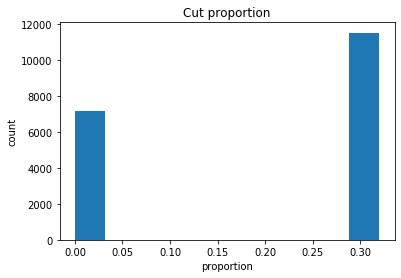

In [6]:
df['prop_cut'] = (df['cut'] / df['profit']).fillna(0)
plt.hist(df['prop_cut'])
plt.title('Cut proportion')
plt.xlabel('proportion')
plt.ylabel('count')
plt.savefig(PLOT / 'cut_proportion')
plt.show()

## top cut district by total

In [7]:
df_sorted = df.sort_values('cut', ascending=False)
df_sorted[['LEAID', 'cut']].head()

,LEAID,cut
1904,0622710,2.059519e+08
7676,2680995,9.943766e+07
3306,1500030,9.523291e+07
15038,4218990,6.616850e+07
6328,2400480,6.383239e+07


# Q2

In [8]:
def bihist(dataOne, dataTwo):
    bins= np.linspace(0 ,1, 11)
    _range = (min(dataOne + dataTwo), max(dataOne + dataTwo))
    hN = plt.hist(dataTwo, bins=bins, orientation='horizontal', normed=0,
        rwidth=0.8, label='Original', range=_range)
    hS = plt.hist(dataOne, bins=bins, orientation='horizontal', normed=0, 
        rwidth=0.8, label='Affected by cut', range=_range)

    for p in hS[2]:
        p.set_width( - p.get_width())

    xmin = min([ min(w.get_width() for w in hS[2]), 
                    min([w.get_width() for w in hN[2]]) ])
    xmin = np.floor(xmin)
    xmax = max([ max(w.get_width() for w in hS[2]), 
                    max([w.get_width() for w in hN[2]]) ])
    xmax = np.ceil(xmax)
    range = xmax - xmin
    delta = 0.0 * range
#     plt.xlim([xmin - delta, xmax + delta])
    plt.xlim(-15000, 15000)
    xt = plt.xticks()
    n = xt[0]
    s = ['%.1f'%abs(i) for i in n]
    plt.xticks(n, s)
    plt.legend(loc='best')
    plt.axvline(0.0)
    plt.ylim(0, 1)

In [9]:
df_ccd['LEAID'] = df_ccd['LEAID'].astype(str)
df_race = df.merge(df_ccd[['LEAID', 'TOTAL', 'AM', 'AS', 'HI', 'BL', 'WH', 'HP', 'TR']])
df_wcut = df_race[df_race['cut'] > 0]

In [10]:
RACE_NAME = {
    'AM': 'American Indian/Alaska Native',
    'AS': 'Asian',
    'HI': 'Hispanic',
    'BL': 'Black',
    'WH': 'White',
    'HP': 'Hawaiian Native/Pacific Islander',
    'TR': 'Two or More Races',
}
def bihist_for_race(race):
    data_one = (df_race[race] / df_race['TOTAL']).fillna(0)
    data_two = (df_wcut[race] / df_race['TOTAL']).fillna(0)
    bihist(data_one, data_two)
    plt.title('Race: {}'.format(RACE_NAME[race]))
    plt.ylabel('Proportion')
    plt.xlabel('LEA count')
    plt.savefig(PLOT / race)
    plt.show()

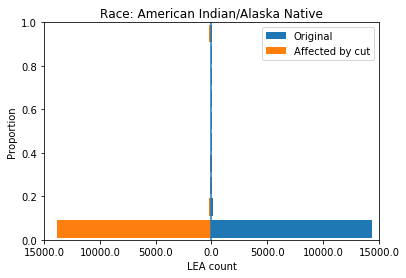

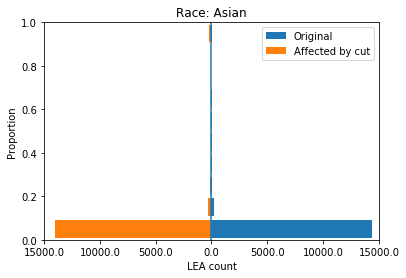

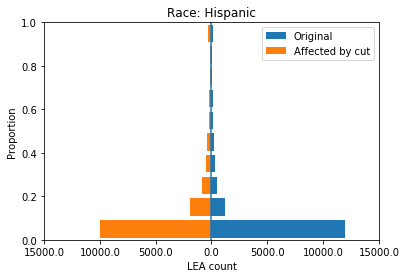

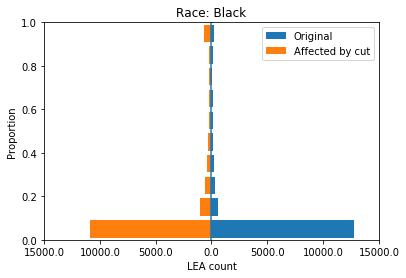

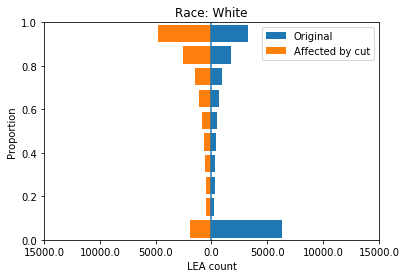

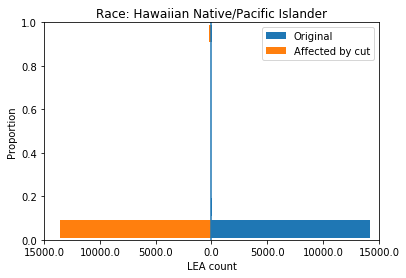

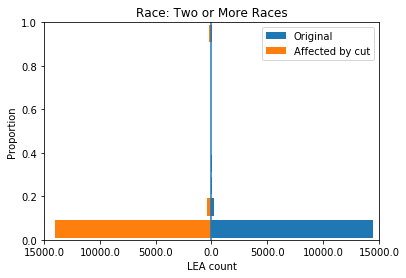

In [11]:
for race in RACE_NAME.keys():
    bihist_for_race(race)

# Q3

In [12]:
df_ccd2 = pd.read_csv('data/ccd_lea_002089_1516_w_1a_011717.csv')
df_ccd2['LEAID'] = df_ccd2['LEAID'].astype(str)
df_dis = df_race.merge(df_ccd2[['LEAID', 'SPECED']])
df_dcut = df_dis[df_dis['cut'] > 0]
df_dis.head(n=2)

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,prop_cut,TOTAL,AM,AS,HI,BL,WH,HP,TR,SPECED
0,1000004,N,10,10003,428,37980,Charter School of Wilmington,Delaware,DE,02,...,0.320191,972,4,279,34,66,586,2,1,0
1,1000005,N,10,10001,428,20100,Positive Outcomes Charter School,Delaware,DE,02,...,0.320191,126,0,1,5,29,89,0,2,79


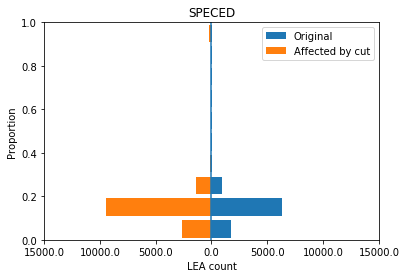

In [13]:
def bihist_for_dis():
    data_one = (df_dis['SPECED'] / df_dis['TOTAL']).fillna(0)
    data_two = (df_dcut['SPECED'] / df_dcut['TOTAL']).fillna(0)
    bihist(data_one, data_two)
    plt.title('SPECED')
    plt.ylabel('Proportion')
    plt.xlabel('LEA count')
    plt.savefig(PLOT / 'SPECED')
    plt.show()
bihist_for_dis()